In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot
import pandas as pd
from scipy.stats import gaussian_kde, linregress
import matplotlib.cm as cm
from utils import u_met
import seaborn
import metpy
from metpy import calc
from metpy.units import units
import statsmodels.api as sm
from scipy import ndimage
import io
import xarray as xr
import pickle
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from numpy.polynomial import polynomial as P

##for regridding, install xesmf:
# conda install esmpy
# pip install xesmf
from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [2]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [4]:
fshear = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/shear_factors.p', "rb"))
ftcw = pickle.load(open('/home/ck/DIR/cornkle/figs/ENDGAME/clim_factors.p', "rb"))

shearfac = fshear['obs_shear'] #0.71 # monthly: 0.55
tcwvfac_all =  ftcw['rel'] 

tcabsfac = np.mean(ftcw['abs']) #1.21 # absolute change

tcabserr = np.std(ftcw['abs']) #0.06 #mm h
tcrelerr = np.std(ftcw['rel']) #0.18 #%

cp4_precip_hist = ftcw['prcp_hist']

ltag = ''

In [5]:
np.median(tcwvfac_all)

1.214592171139146

In [6]:
shearfac

0.7003135334190702

In [7]:
print(fshear.keys())
print(ftcw.keys())

dict_keys(['obs_shear', 'cp4_shear'])
dict_keys(['rel', 'abs', 'futslope', 'histslope', 'futinter', 'histinter', 'tcw_hist', 'prcp_hist'])


In [8]:
base = '/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/'

dics = ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut']
cp4_read = {'period' : [], 'shear' : [], 'tcwv' : []}
for dd in dics:
   
    dic = pd.read_csv(base+dd+'_vars_DAILY'+ltag+'.csv', index_col=0)

    cp4_read['period'].append(dd)
    cp4_read['shear'].append(np.array(dic.loc['shear']))
    cp4_read['tcwv'].append(np.array(dic.loc['tcwv']))


In [9]:
cp4_read

{'period': ['CP4hist', 'CP4fut', 'CP25hist', 'CP25fut'],
 'shear': [array([14.449758]),
  array([17.2547]),
  array([14.538405]),
  array([16.056562])],
 'tcwv': [array([40.219635]),
  array([60.118057]),
  array([40.55196]),
  array([60.97515])]}

In [10]:
cp4_df = pd.DataFrame.from_dict(cp4_read)
cp4_df = cp4_df.set_index('period')

In [11]:
cp4_df.loc['CP25fut','shear']

array([16.056562])

In [12]:
cp4_df.loc['CP25hist','shear']

array([14.538405])

In [13]:
cp4_shear_diff = (cp4_df.loc['CP4fut', 'shear']-cp4_df.loc['CP4hist', 'shear'])#/cp4_df.loc['CP4hist', 'shear']*100
cp25_shear_diff = (cp4_df.loc['CP25fut', 'shear']-cp4_df.loc['CP25hist', 'shear'])#/cp4_df.loc['CP25hist', 'shear']*100

cp4_tcwv_diff = (cp4_df.loc['CP4fut', 'tcwv']-cp4_df.loc['CP4hist', 'tcwv'])/cp4_df.loc['CP4hist', 'tcwv']
cp25_tcwv_diff = (cp4_df.loc['CP25fut', 'tcwv']-cp4_df.loc['CP25hist', 'tcwv'])/cp4_df.loc['CP25hist', 'tcwv']

cp4_historical_domainMean = cp4_df.loc['CP4hist', 'tcwv']
cp4_future_domainMean = cp4_df.loc['CP4fut', 'tcwv']

In [14]:
cp4_historical_domainMean

array([40.219635])

In [15]:
cp4_future_domainMean-cp4_historical_domainMean

array([19.898422])

In [16]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP5/endgame/'
dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
cmip_read = {}
for dd in dics:
    cmip_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP'+ltag+'.csv', index_col='model_name')
#     (cmip_read[dd[1]])['shear_mean_precip'] = (cmip_read[dd[1]])['shear_mean'] 
#     (cmip_read[dd[1]])['tcw_mean_precip'] = (cmip_read[dd[1]])['tcwv_mean'] 
#     (cmip_read[dd[1]])['shear_perc_'] = (cmip_read[dd[1]])['tcwv_mean'] 

In [17]:
cmip_read['2040']

,Unnamed: 0,shear_mean,tcw_mean,tcw_hist,shear_hist
model_name,,,,,
GISS-E2-R-CC,0,1.144176,5.883850,42.508641,14.398726
CMCC-CESM,1,0.715928,6.893046,43.708276,11.422506
GFDL-ESM2G,2,0.502048,6.217752,41.297660,9.457985
CMCC-CMS,3,0.652355,7.694750,40.242870,12.500554
CCSM4,4,0.919500,6.422577,37.848718,13.227574
inmcm4,5,0.920689,2.642078,34.653000,14.499242
MIROC-ESM,6,2.055392,11.634339,34.982773,11.600923
MIROC5,7,0.001726,7.255250,43.710976,16.115363
GISS-E2-H,8,1.340425,6.227668,41.088391,15.156345


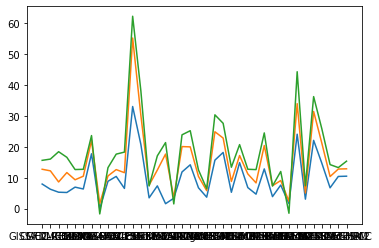

In [18]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['shear_mean']/((cmip_read[y])['shear_hist'])*100)

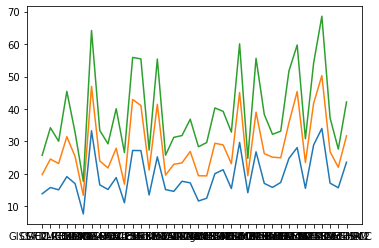

In [19]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist'])*100)

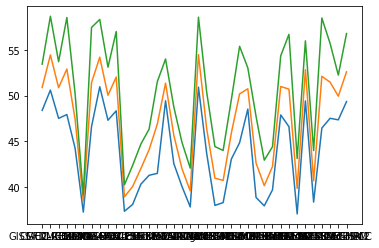

In [20]:
for y in ['2040','2060', '2080']:
    plt.plot(cmip_read[y]['tcw_mean']+((cmip_read[y])['tcw_hist']))

In [21]:
np.percentile(cmip_read[y]['tcw_mean']/((cmip_read[y])['tcw_hist']),90)

0.5703801581509201

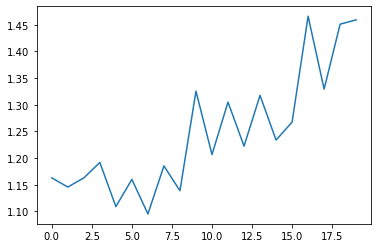

In [22]:
plt.plot(tcwvfac_all)

In [23]:
np.median(tcwvfac_all)

1.214592171139146

In [24]:
len(tcwvfac_all)

20

In [25]:
np.sort(tcwvfac_all)[11]

1.2338372139244471

10,90 perc tcw model bcc-csm1-1 HadGEM2-CC
10,90 perc tcw model CSIRO-Mk3-6-0 ACCESS1-3
10,90 perc tcw model FIO-ESM ACCESS1-3


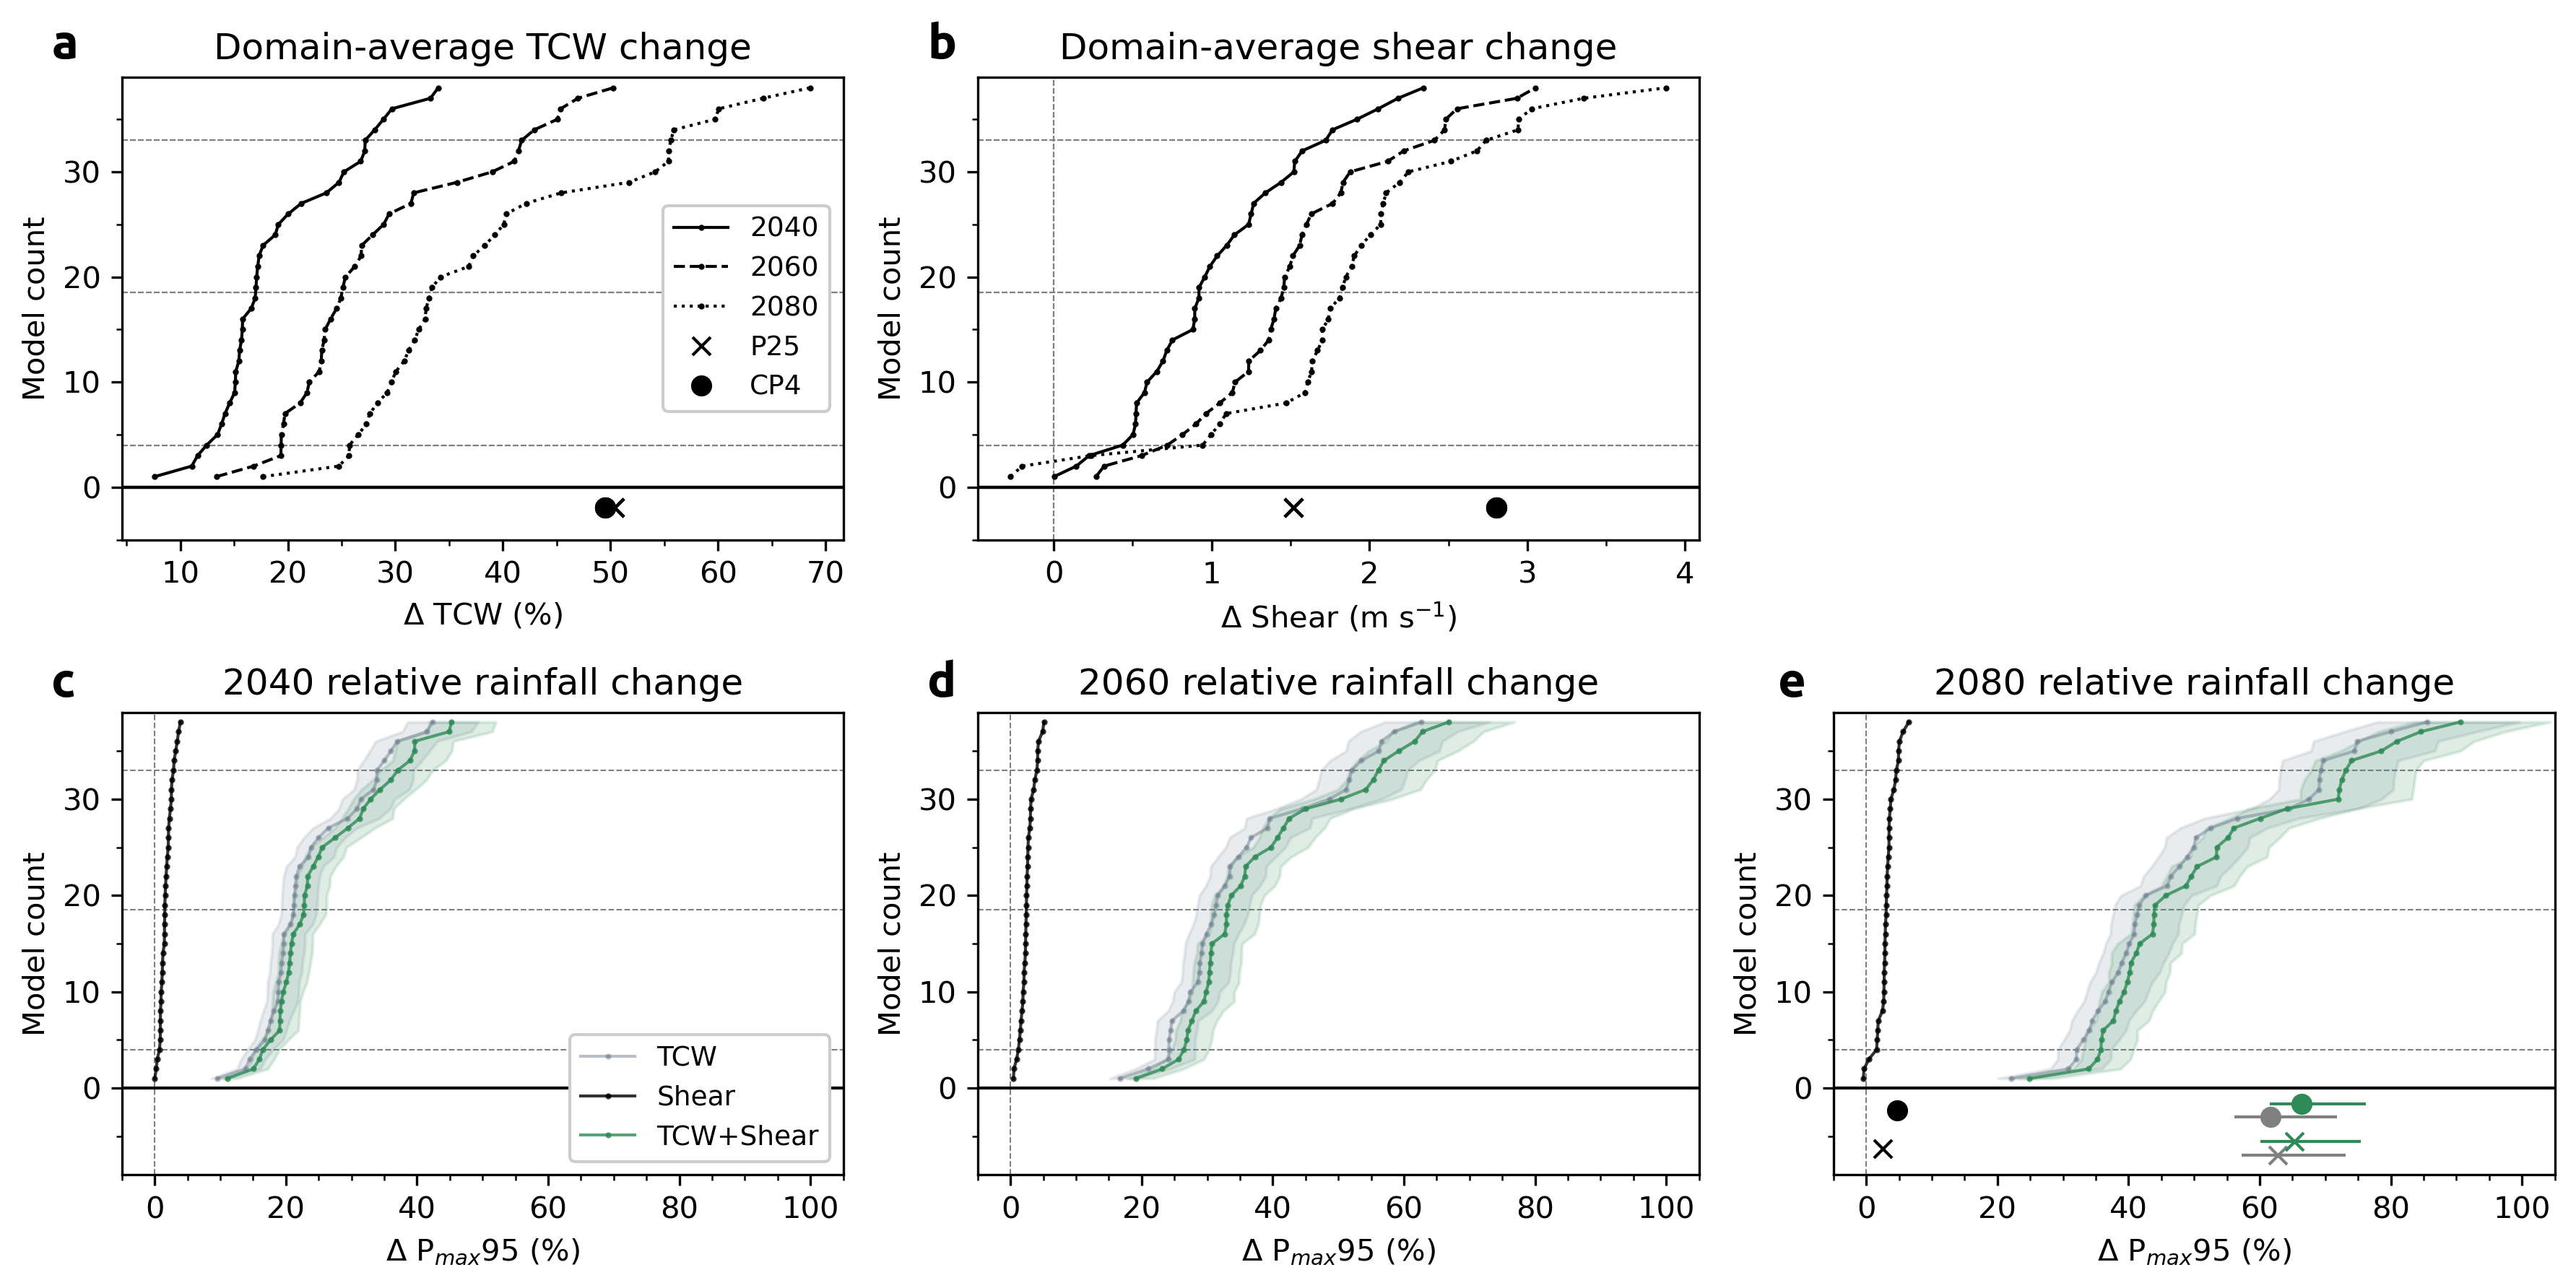

In [26]:
#tcwvfac = tcwvfac_all[np.argmin(np.abs(cp4_historical_domainMean- ftcw['tcw_hist']))] #take tcw scaling for CP4 baseline tcw (37.2 mm domain wide) - it's the average scaling, where lower  
tcwvfac = np.mean(tcwvfac_all)
    
f = plt.figure(figsize=(12,6), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

perc_dic = {}


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = ((cmip_read[stry])['tcw_mean'])/(cmip_read[stry])['tcw_hist'] *100
    cmean = np.mean(x)
    cumulative = np.sort(x)
    posimean = np.argmin(np.abs(cmean-cumulative))

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)

    ax1.set_title(r'Domain-average TCW change')
    ax1.set_xlabel('$\Delta$ TCW (%)')  #kg m$^{-2}$
    ax1.set_ylabel('Model count')


    x = (cmip_read[stry])['shear_mean']
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=1, color='k', linestyle=linestyle[ids], linewidth=1)
    
    ax2.set_title(r'Domain-average shear change')
    ax2.set_xlabel('$\Delta$ Shear (m s$^{-1}$)')
    ax2.set_ylabel('Model count')
    
    if ids == 2:

        ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')

        ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x', label='P25', linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o', label='CP4', linestyle='')
    else:
        
        shiftfac=2
        ax1.plot(cp25_tcwv_diff*100,0.03-shiftfac, color='k', marker='x', linestyle='')
        ax1.plot(cp4_tcwv_diff*100,0.03-shiftfac, color='k', marker='o', linestyle='')

        ax2.plot(cp25_shear_diff,0.03-shiftfac, color='k', marker='x',  linestyle='')
        ax2.plot(cp4_shear_diff,0.03-shiftfac, color='k', marker='o',  linestyle='')
        
        
    ax1.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax1.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)

    ax1.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax2.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax2.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    
    ax1.axhline(0, linestyle='solid', lw=1, color='k')
    ax2.axhline(0, linestyle='solid', lw=1, color='k')
    ax1.set_ylim(-5,39)
    ax2.set_ylim(-5,39)
    
    ax1.xaxis.set_minor_locator(MultipleLocator(5))
    ax1.yaxis.set_minor_locator(MultipleLocator(5))
    
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.yaxis.set_minor_locator(MultipleLocator(5))
    
    
    #########################################
    ########################################
    #########################################
    
    ax = f.add_subplot(2,3,ids+4)
    ##########
    ax.axhline(18.5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(4, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(33, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    fdic = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.percentile(tcwvfac_all,10), np.percentile(tcwvfac_all,90)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.percentile(cp4_precip_hist,10)
        if fag == 'max':
            pcphist = np.percentile(cp4_precip_hist,90)
        
        x = (cmip_read[stry])['tcw_mean']/(cmip_read[stry])['tcw_hist'] * tcwvfac *100 # /cp4_historical_domainMean * tcwvfac *100 #/(cmip_read[stry])['tcw_hist']) * tcwvfac *100
        cumulative = np.sort(x)  # percentage rainfall increase from relative CMIP change

        order = np.argsort(x)
        mnames = (cmip_read['2040']).index[order]

            
        cmip_p_from_shear = (cmip_read[stry]).shear_mean[order] *shearfac  # absolute rainfall from CMIP shear change
        cmip_p_from_tcw = pcphist*cumulative/100  # 
        cmip_perc_per_mm = cumulative/cmip_p_from_tcw
        cmip_perc_shear = cmip_p_from_shear * cmip_perc_per_mm

        cmip_shear_ordered = np.sort(cmip_perc_shear)
        cmip_total_ordered = np.sort(cumulative+cmip_perc_shear)
        fdic[fag]=(cumulative,cmip_shear_ordered,cmip_total_ordered)

        
    perc_num = np.arange(len((cmip_read[stry])['tcw_mean']))
    perc = np.round(np.percentile(perc_num, [10,90]),0).astype(int)
    
    print('10,90 perc tcw model', mnames[perc[0]], mnames[perc[-1]])
    perc_dic[stry] = {'tcw': (mnames[perc[0]], mnames[perc[-1]])}

    ax.plot(fdic['mean'][0], np.arange(len(fdic['mean'][0]))+1, color='slategrey', alpha=0.5, label='TCW', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][0]))+1, fdic['min'][0], fdic['max'][0], color='slategrey', alpha=0.15, zorder=99)
    
    ax.plot(fdic['mean'][1], np.arange(len(fdic['mean'][0]))+1, color='k', alpha=0.8, label='Shear', marker='o', markersize=1, zorder=99, linewidth=1) 
    
    ax.plot(fdic['mean'][2], np.arange(len(fdic['mean'][0]))+1, color='seagreen', alpha=0.8, label='TCW+Shear', marker='o', markersize=1, zorder=99, linewidth=1)
    ax.fill_betweenx(np.arange(len(fdic['mean'][2]))+1, fdic['min'][2], fdic['max'][2], color='seagreen', alpha=0.15, zorder=99)
    
#     if stry=='2080':
#         ipdb.set_trace()
    
    ax.axvline(0, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    #ax.axvline(5, linestyle='dashed', lw=0.5, color='grey', zorder=0)
    ax.axhline(0, linestyle='solid', lw=1, color='k')
    
    ax.xaxis.set_minor_locator(MultipleLocator(5))
    ax.yaxis.set_minor_locator(MultipleLocator(5))

    
    ##############
    fdic4 = {'min' : [], 'max' : [], 'mean':[]}
    fdic25 = {'min' : [], 'max' : [], 'mean':[]}
    for fag, tcwvfac in zip(['mean','min','max'],[np.mean(tcwvfac_all), np.percentile(tcwvfac_all,10), np.percentile(tcwvfac_all,90)]):
        
        if fag == 'mean':
            pcphist = np.mean(cp4_precip_hist)
        if fag == 'min':
            pcphist = np.percentile(cp4_precip_hist,10)
        if fag == 'max':
            pcphist = np.percentile(cp4_precip_hist,90)
        
        cp4_perc_tcw = cp4_tcwv_diff * tcwvfac  #/cp4_historical_domainMean
        cp4_p_from_shear = cp4_shear_diff *shearfac
        #ipdb.set_trace()
        cp4_p_from_tcw = cp4_perc_tcw * pcphist
        cp4_perc_per_mm = cp4_perc_tcw/cp4_p_from_tcw
        cp4_perc_shear = cp4_p_from_shear * cp4_perc_per_mm

        cp25_perc_tcw = cp25_tcwv_diff * tcwvfac  # /cp4_historical_domainMean
        cp25_p_from_shear = cp25_shear_diff *shearfac
        cp25_p_from_tcw = cp25_perc_tcw *pcphist 
        cp25_perc_per_mm = cp25_perc_tcw/cp25_p_from_tcw
        cp25_perc_shear = cp25_p_from_shear * cp25_perc_per_mm
        
        fdic4[fag]=(cp4_perc_tcw,cp4_perc_shear,cp4_perc_tcw+cp4_perc_shear)
        fdic25[fag]=(cp25_perc_tcw,cp25_perc_shear,cp25_perc_tcw+cp25_perc_shear)

    if ids == 2:

        shiftfac = 7
        ax.errorbar(np.array(fdic25['mean'][0])*100,0.03-shiftfac, xerr=[(fdic25['mean'][0]-fdic25['min'][0])*100, (fdic25['max'][0]-fdic25['mean'][0])*100], color='grey', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][0]*100,4-shiftfac,  xerr=[(fdic4['mean'][0]-fdic4['min'][0])*100, (fdic4['max'][0]-fdic4['mean'][0])*100],color='grey', marker='o', linewidth=1)
        ax.errorbar(fdic25['mean'][1]*100,0.73-shiftfac,  xerr=[(fdic25['mean'][1]-fdic25['min'][1])*100, (fdic25['max'][1]-fdic25['mean'][1])*100],color='k', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][1]*100,4.7-shiftfac,  xerr=[(fdic4['mean'][1]-fdic4['min'][1])*100, (fdic4['max'][1]-fdic4['mean'][1])*100],color='k', marker='o', linewidth=1)
        ax.errorbar(fdic25['mean'][2]*100,1.43-shiftfac,  xerr=[(fdic25['mean'][2]-fdic25['min'][2])*100, (fdic25['max'][2]-fdic25['mean'][2])*100],color='seagreen', marker='x', linewidth=1)
        ax.errorbar(fdic4['mean'][2]*100,5.4-shiftfac,  xerr=[(fdic4['mean'][2]-fdic4['min'][2])*100, (fdic4['max'][2]-fdic4['mean'][2])*100],color='seagreen', marker='o', linewidth=1)
        
        #ax.errorbar(pcp4f['rbins'], pcp4f['pmean'], xerr=np.array(fdic4['mean'][0]*100-fdic4['mean'][0]*100), color='xkcd:tomato', linewidth=0.5, linestyle='')
   
    plt.xlabel('$\Delta$ P$_{max}95$ (%)')
    plt.ylabel('Model count')
    ax.set_xlim(-5,105)
    ax.set_ylim(-9,39)

    plt.title(stry +' relative rainfall change')
    if ids == 0:
        plt.legend(loc='lower right', fontsize=9, framealpha=1)  #facecolor='lightgrey'
ax1.legend(fontsize=9, framealpha=1)
#ax2.legend()

#ipdb.set_trace()
plt.tight_layout()
text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.02, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.945), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.02, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.69, 0.45), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_order_Sahel_inclCP4_rel_hourlyScaling_relToCMIP_9-19N_20masked_8mm.jpg')

In [27]:
perc_dic

{'2040': {'tcw': ('bcc-csm1-1', 'HadGEM2-CC')},
 '2060': {'tcw': ('CSIRO-Mk3-6-0', 'ACCESS1-3')},
 '2080': {'tcw': ('FIO-ESM', 'ACCESS1-3')}}

In [23]:
pkl.dump(perc_dic, open('/home/ck/DIR/cornkle/figs/ENDGAME/dave_map/CMIPpercentiles_1090_Sahel_tcwShear.p', "wb"))

In [24]:
from scipy.stats import gaussian_kde

def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

NameError: name 'mmPerPercent' is not defined

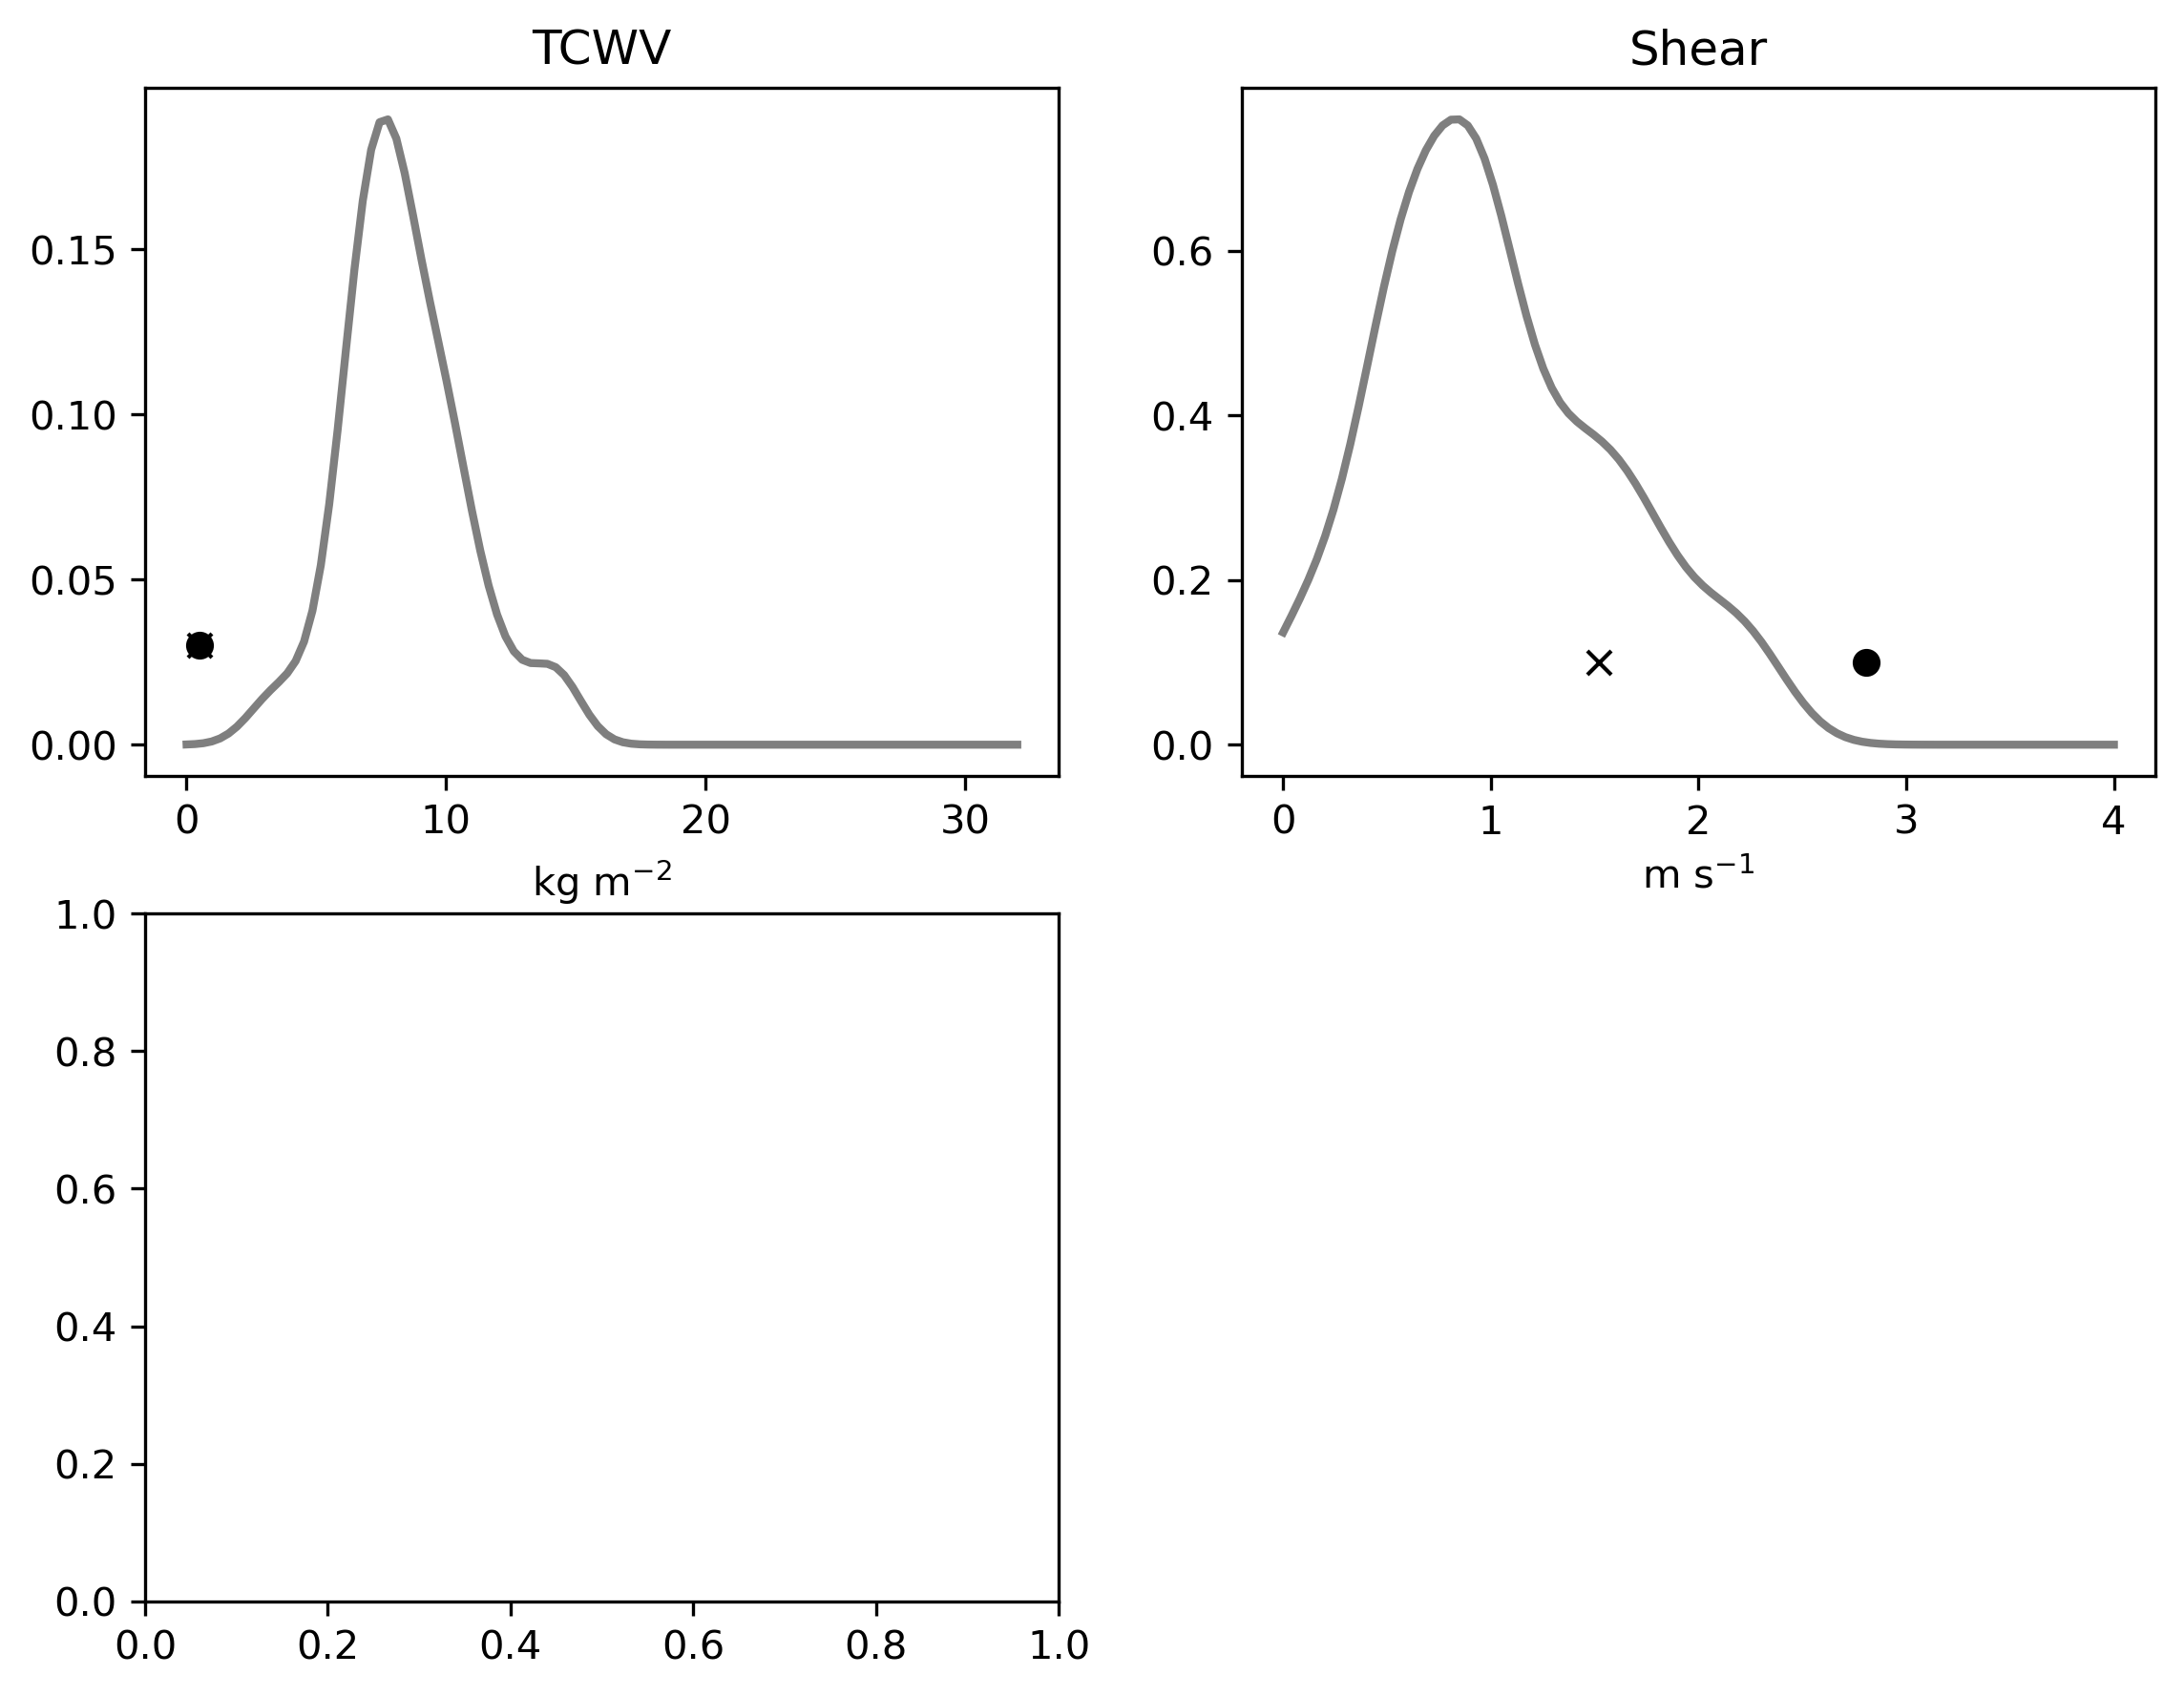

In [25]:

f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)


linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac
    x_grid = np.linspace(0, 32, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1)
    ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    #ax1.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
#         x = cmip_sahel_tcw.values[np.isfinite(cmip_sahel_tcw.values)]
#         x_grid = np.linspace(0, 25, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=1)
#         ax1.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax1.set_title('TCWV')
#         ax1.set_xlabel('kg m$^{-2}$')
#         #ax1.axvline(0, linestyle='dashed', lw=1)
        
    
    
    #
    x = (cmip_read[stry])['shear_mean']
    x_grid = np.linspace(0, 4, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=0.2)
    ax2.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    #plt.axvline(0, linestyle='dashed', lw=1)
    
#     if ids == 2:
        
#         x = cmip_sahel_sh.values[np.isfinite(cmip_sahel_sh.values)]
#         x_grid = np.linspace(-3, 1, 100)
#         pdf = kde_scipy(x, x_grid, bandwidth=0.2)
#         ax2.plot(x_grid, pdf, color='b', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
#         ax2.set_title('Shear')
#         ax2.set_xlabel('m s$^{-1}$')
#         #plt.axvline(0, linestyle='dashed', lw=1)
        
    ax1.plot(cp25_tcwv_diff,0.03, color='k', marker='x')
    ax1.plot(cp4_tcwv_diff,0.03, color='k', marker='o')
    #ax1.plot(cp4_sahel_tcw, 0.03, color='grey', marker='o')
    ax2.plot(cp25_shear_diff,0.1, color='k', marker='x')
    ax2.plot(cp4_shear_diff,0.1, color='k', marker='o')
    #ax2.plot(cp4_sahel_shear, 0.03, color='grey', marker='o')
        

    ax = f.add_subplot(2,3,ids+4)
    ##########
    #tcplot = hist2d.basic_1d_binning(cmip_tc_perc['2080'].values, np.arange(np.min(cmip_tc_perc['2080']), np.max(cmip_tc_perc['2080']),1))
    #ax.bar(tcplot['xbins'], tcplot['nb']/np.sum(tcplot['nb']), color='grey', label='TCWV')

    x = ((cmip_read[stry])['tcw_mean']) * tcabsfac  / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='slategrey', alpha=0.5, lw=2, label='TCWV')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = ((cmip_read[stry])['shear_mean']) * shearfac / mmPerPercent
    x_grid = np.linspace(0, 10, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='k', alpha=0.8, lw=2, label='Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = (((cmip_read[stry])['shear_mean']) * shearfac + ((cmip_read[stry])['tcw_mean']) * tcabsfac) / mmPerPercent
    x_grid = np.linspace(0, 85, 100)
    pdf = kde_scipy(x, x_grid, bandwidth=1.5)
    ax.plot(x_grid, pdf, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
#     if ids == 2:
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.01, color='grey', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.01, color='grey', marker='o')
#         ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.01, color='k', marker='x')
#         ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='k', marker='o')
#         ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.01, color='seagreen', marker='x')
#         ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.01, color='seagreen', marker='o')
        
    if ids == 2:
        ax.plot(cp25_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='x')
        ax.plot(cp4_tcwv_diff * tcabsfac/ mmPerPercent,0.03, color='grey', marker='o')
        ax.plot(cp25_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='x')
        ax.plot(cp4_shear_diff* shearfac / mmPerPercent,0.03, color='k', marker='o')
        ax.plot((cp25_shear_diff * shearfac +  cp25_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='x')
        ax.plot((cp4_shear_diff * shearfac +  cp4_tcwv_diff * tcabsfac)/ mmPerPercent,0.03, color='seagreen', marker='o')

    plt.xlabel('%')
    plt.ylabel('Density')

    plt.title(stry)

    plt.legend()
ax1.legend()
ax2.legend()
plt.tight_layout()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)

plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_PDF_Sahelonly.png')

In [ ]:
f = plt.figure(figsize=(14,7), dpi=300)
ax1 = f.add_subplot(2,3,1)
ax2 = f.add_subplot(2,3,2)

mk=3
linestyle = ['solid', 'dashed', 'dotted']
for ids, stry in enumerate(['2040', '2060', '2080']):
    

    ##########
    x = cmip_tc_diff[stry].values[np.isfinite(cmip_tc_diff[stry].values)]
    cumulative = np.sort(x)

    ax1.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    #ax1.plot(x_grid, pdf, color='k', alpha=0.5, lw=2, label=stry, linestyle=linestyle[ids])
    ax1.set_title('TCWV')
    ax1.set_xlabel('kg m$^{-2}$')
    ax1.set_ylabel('Model number')

    ax1.plot(cp4_diff.loc['tcw', 'R25DELTA'],0.03, color='k', marker='x')
    ax1.plot(cp4_diff.loc['tcw', 'CP4DELTA'],0.03, color='k', marker='o')
    ax2.plot(cp4_diff.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
    ax2.plot(cp4_diff.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')

    #ax1.axvline(0, linestyle='dashed', lw=1)
    
    
    #
    x = cmip_sh_diff[stry].values[np.isfinite(cmip_sh_diff[stry].values)]
    cumulative = np.sort(x)

    ax2.plot(cumulative, np.arange(len(cumulative))+1, label=stry, marker='o', markersize=mk, color='k', linestyle=linestyle[ids])
    ax2.set_title('Shear')
    ax2.set_xlabel('m s$^{-1}$')
    ax2.set_ylabel('Model number')
    #plt.axvline(0, linestyle='dashed', lw=1)

    ax = f.add_subplot(2,3,ids+4)
    ##########
    x = cmip_tc_perc[stry].values[np.isfinite(cmip_tc_perc[stry].values)]
    cumulative = np.sort(x)

    ax.plot(cumulative, np.arange(len(cumulative))+1, color='slategrey', alpha=0.5, lw=2, label='TCWV', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #shplot = hist2d.basic_1d_binning(cmip_sh_precip['2080'].values, np.arange(np.min(cmip_sh_precip['2080']), np.max(cmip_sh_precip['2080']),0.1))
    #ax.bar(shplot['xbins'], shplot['nb']/np.sum(shplot['nb']), color='k', label='Shear', width=0.1)
    ##----
    x = cmip_sh_perc[stry].values[np.isfinite(cmip_sh_perc[stry].values)]
    cumulative = np.sort(x)
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='k', alpha=0.8, lw=2, label='Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')

    ###
    #stplot = hist2d.basic_1d_binning(cmip_shtc_precip[stry].values, np.arange(np.min(cmip_shtc_precip[stry]), np.max(cmip_shtc_precip[stry]),1))
    #ax.bar(stplot['xbins'], stplot['nb']/np.sum(stplot['nb']), color='seagreen', label='TCWV+Shear')
    ##----
    x = cmip_shtc_precip[stry].values[np.isfinite(cmip_shtc_precip[stry].values)]
    cumulative = np.sort(x)
    
    ax.plot(cumulative, np.arange(len(cumulative))+1, color='seagreen', alpha=0.8, lw=2,  label='TCWV+Shear', marker='o', markersize=mk, linestyle='solid')
    ax.axvline(0, linestyle='dashed', lw=1, color='grey')
    ##############
    if ids == 2:
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA'],0.03, color='grey', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA'],0.03, color='grey', marker='o')
        ax.plot(cp4_precip.loc['shear', 'R25DELTA'],0.03, color='k', marker='x')
        ax.plot(cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='k', marker='o')
        ax.plot(cp4_precip.loc['tcw', 'R25DELTA']+cp4_precip.loc['shear', 'R25DELTA'],0.03, color='seagreen', marker='x')
        ax.plot(cp4_precip.loc['tcw', 'CP4DELTA']+cp4_precip.loc['shear', 'CP4DELTA'],0.03, color='seagreen', marker='o')
   
    plt.xlabel('%')
    plt.ylabel('Model number')

    plt.title(stry)
    if ids == 0:
        plt.legend()
ax1.legend()
#ax2.legend()

#ipdb.set_trace()

text = ['a', 'b', 'c', 'd', 'e']
plt.annotate(text[0], xy=(0.006, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[1], xy=(0.36, 0.96), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
# plt.annotate(text[2], xy=(0.68, 0.94), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
#              textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[2], xy=(0.006, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[3], xy=(0.36, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.annotate(text[4], xy=(0.68, 0.47), xytext=(0, 4), xycoords=('figure fraction', 'figure fraction'),
             textcoords='offset points', fontweight='bold', fontname='Ubuntu', fontsize=16)
plt.tight_layout()
#plt.savefig(cnst.network_data + 'figs/ENDGAME/CMIP_driver_marker+uncertainty.png')

In [26]:
start = 1
nums = []
nums.append(start)
for ix in range(len(np.arange(15,65))):
    start = start+start*0.07
    nums.append(start)
    

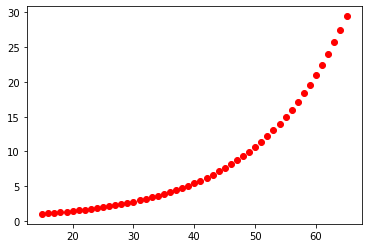

In [27]:
plt.plot(np.arange(15,66), nums,'or')

In [28]:
x = np.arange(15,56)
y = np.array(nums)

In [29]:
y[1::]-y[0:-1]

array([0.07      , 0.0749    , 0.080143  , 0.08575301, 0.09175572,
       0.09817862, 0.10505112, 0.1124047 , 0.12027303, 0.12869214,
       0.1377006 , 0.14733964, 0.15765341, 0.16868915, 0.18049739,
       0.19313221, 0.20665146, 0.22111706, 0.23659526, 0.25315693,
       0.27087791, 0.28983937, 0.31012812, 0.33183709, 0.35506569,
       0.37992028, 0.4065147 , 0.43497073, 0.46541869, 0.49799799,
       0.53285785, 0.5701579 , 0.61006896, 0.65277378, 0.69846795,
       0.7473607 , 0.79967595, 0.85565327, 0.915549  , 0.97963743,
       1.04821205, 1.12158689, 1.20009797, 1.28410483, 1.37399217,
       1.47017162, 1.57308364, 1.68319949, 1.80102346, 1.9270951 ])

In [30]:
(y[5]-y[1])/y[1]

0.31079601000000007

In [31]:
(y[35]-y[25])/y[25]

0.9671513572895657

In [32]:
(y[25]-y[15])/y[15]

0.9671513572895657

In [33]:
(x[10+a]-x[1+a])

NameError: name 'a' is not defined